# 0.0 Imports

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import inflection
import datetime as dt
import re
import warnings

from sklearn import cluster as c
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import calinski_harabasz_score,davies_bouldin_score
from sklearn import metrics as m

from plotly import express as px

from IPython.display import Image
from IPython.core.display import HTML
warnings.filterwarnings('ignore')

## 0.1 Helper Function

In [31]:
 def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

def hyperparameter_tunning(model, clusters,data):
    # wss
    wss = kmeans = KElbowVisualizer(c.KMeans(),k=clusters,
                         timings=False )
    wss.fit(data)
    # ss 
    ss = KElbowVisualizer(c.KMeans(),
                         k=clusters,
                         metric='silhouette',
                         timings=False)
    ss.fit(data)
    df = pd.DataFrame({'Metric': ['WSS','SS'], 'Score':[wss.elbow_score_.round(2),ss.elbow_score_.round(2)],
                       'Recomended k':[wss.elbow_value_,ss.elbow_value_]})
    return df
   

Populating the interactive namespace from numpy and matplotlib


# 0.2 Loading Data

In [32]:
df = pd.read_csv('../data/raw/Ecommerce.csv')
df.drop('Unnamed: 8', axis=1,inplace=True)

# 1.0 Data Description

In [33]:
df1 = df.copy()

* Invoice Number: identificador único de cada transação.
* Stock Code Product: código do item.
* Description Product: nome do item
* Quantity: A quantidade de cada item comprado por transação.
* Invoice Date: O dia em que a transação ocorreu
* Unit Price: Preço do produto por unidade
* Customer ID: identificador único do cliente
* Country: O nome do país que o cliente resid

In [34]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.1 Rename columns

In [35]:
old_cols = df1.columns.tolist()

snakecase = lambda x: inflection.underscore(x)

new_cols = list(map(snakecase, old_cols))

# Rename columns
df1.columns = new_cols

## 1.2 Data Dimension

In [36]:
print('Number of row: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of row: 541909
Number of columns: 8


## 1.3 Data Types

In [37]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NAs

In [38]:
df1.isna().sum()[df1.isna().sum()>0]

description      1454
customer_id    135080
dtype: int64

## 1.5 Replace NAs

At this first CRISP cycle, we'll simply remove the NAs.

In [39]:
(df1.shape[0]/df.shape[0])

1.0

In [40]:
# remove NAs
df1.dropna(subset=['description','customer_id'], inplace=True)
print('Percentage of Removed Values: {:.2f}'.format(1-(df1.shape[0]/df.shape[0])))

Percentage of Removed Values: 0.25


In [41]:
# Check NAs agains
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.6 Change data types

In [42]:
# invoice date
df1['invoice_date'] =  pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype( int )

In [43]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int32
country                 object
dtype: object

## 1.7 Descriptive Statistics

Let's leave this step to the next CRISP cycles.

# 2.0 Feature Engeneering

In [44]:
df2 = df1.copy()

## 2.1 Feature Creating

In [45]:
# Data reference
df_ref = df2[['customer_id']].drop_duplicates().reset_index()
df_ref.drop('index',axis=1, inplace=True)

# Gross Revenue (faturamento)
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

# Monetary
df_monetary = df2[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref  =pd.merge(df_ref, df_monetary, on='customer_id', how='left')

# Recency - Last Day purchase
df_recency = df2[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max()-df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id','recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id',how='left')

# Frequency
df_freq =df2[['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='customer_id',how='left')

# 3.0 Feature Filtering

In [46]:
df3 =df_ref.copy()

# 4.0 Exploratory Data Analysis

In [47]:
df4 = df3.copy()

# 5.0 Data Preparation

In [48]:
df5 = df4.copy()

# 6.0 Feature Selection

In [49]:
df6 = df5.copy()

# 7.0 Hyperparameter Fine-Tunning

This step servers for testing how many clusters fits the model the best.

In [50]:
X = df6.drop('customer_id',axis=1)

In [51]:
# Listing possible values for k
clusters =[2,3,4,5,6]


## 7.1 Within-Cluster Sum of Square (WSS)

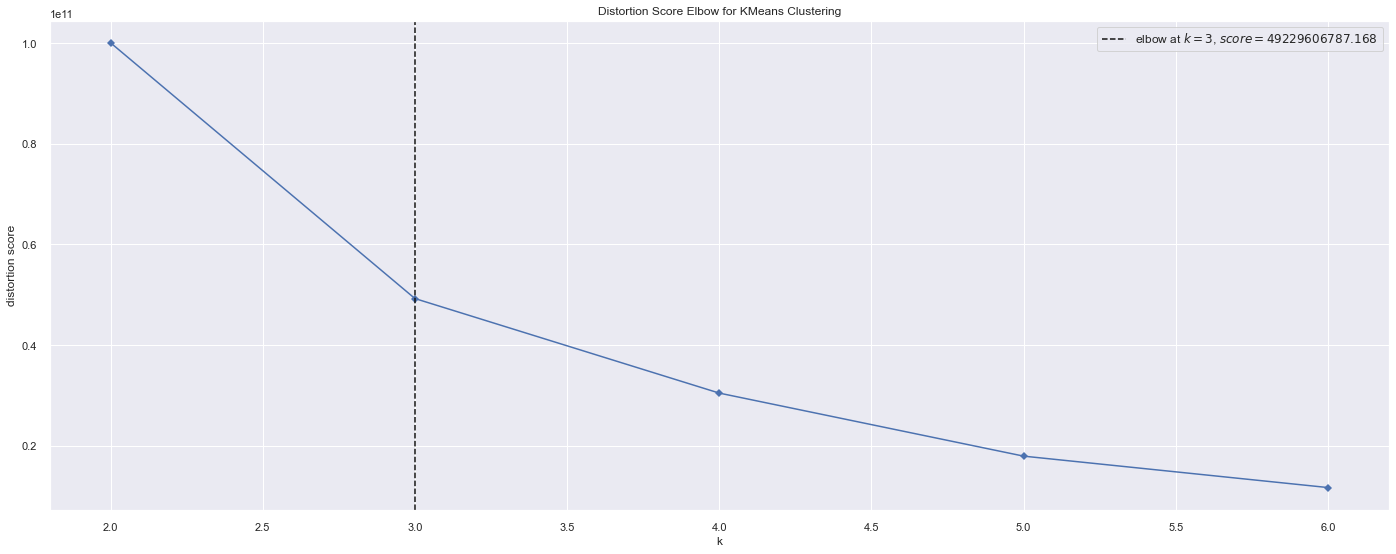

In [52]:
kmeans = KElbowVisualizer(c.KMeans(),k=clusters,
                         timings=False )
kmeans.fit(X)
kmeans.show();

## 7.2 Sillhouette Score

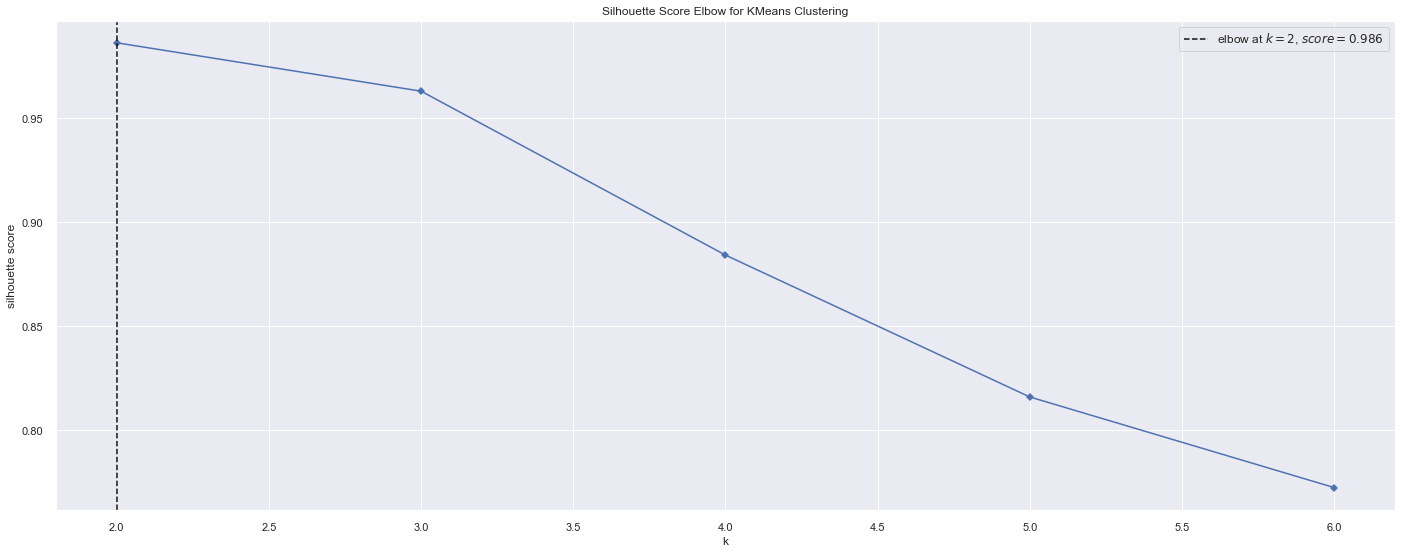

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [53]:
kmeans = KElbowVisualizer(c.KMeans(),
                         k=clusters,
                         metric='silhouette',
                         timings=False)
kmeans.fit(X)
kmeans.show()

In [54]:
def hyperparameter_tunning(model, clusters,data):
    # wss
    wss = KElbowVisualizer(c.KMeans(),k=clusters,
                         timings=False )
    wss.fit(data)
    # ss 
    ss = KElbowVisualizer(c.KMeans(),
                         k=clusters,
                         metric='silhouette',
                         timings=False)
    ss.fit(data)
    df = pd.DataFrame({'Metric': ['WSS','SS'], 'Score':[wss.elbow_score_.round(2),ss.elbow_score_.round(2)],
                       'Recomended k':[wss.elbow_value_,ss.elbow_value_]})
    return df
   

# 8.0 Model Training

## 8.1 K-Means

In [63]:
# Model definition
k =3
kmeans = c.KMeans (init='random', n_clusters = k, n_init=10,max_iter=300)

# Model training
kmeans.fit(X)

# Clustering
labels = kmeans.labels_

## 8.2 Cluster Validation

In [56]:
## WSS
print('WSS value:',kmeans.inertia_)

# SS
print('SS value:', m.silhouette_score(X, labels))

WSS value: 52830442008.00694
SS value: 0.9494677566681544


# 9.0 Cluster Analysis

In [64]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,cluster
0,17850,5288.63,302,35,2
1,13047,3079.10,31,18,2
2,12583,7187.34,2,18,2
3,13748,948.25,95,5,2
4,15100,635.10,330,6,2


## 9.1 Perfomance Avaliation

### Calinski and Harabasz score

The score is the ratio of the sum of between-clusters dispersion and of inter-cluster dispersion for all clusters. The higher the score , the better the performance.

In [58]:
ch = calinski_harabasz_score(X[['gross_revenue','recency_days','invoice_no']],X['cluster'])
ch

KeyError: 'cluster'

### Davies-Bouldin score

The score is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. Thus, clusters which are farther apart and less dispersed will result in a better score.

The minimum score is zero, with lower values indicating better clustering.

In [ ]:
db = davies_bouldin_score(X[['gross_revenue','recency_days','invoice_no']],X['cluster'])
db

## 9.2 Visualization Inspection

In [65]:
fig =px.scatter_3d(df9,  x='recency_days', y='invoice_no', z='gross_revenue', color='cluster' )
fig.show()

In [60]:
# Number of customers
df_cluster = df9[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Average Gross Revenue
df_avg_gross_rev = df9[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_rev, how='inner',on='cluster')

# Average Recency Days
df_avg_rec_days = df9[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_rec_days, how='inner',on='cluster')

# Averaga Invoice Number
df_avg_invoice_no = df9[['invoice_no','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner',on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no
0,0,4335,99.153705,1372.577826,92.257901,4.614533
1,1,6,0.137237,182181.981667,7.166667,89.000000
2,2,31,0.709058,40543.517742,13.290323,53.290323


 Cluster 01:  ( Candidato à Insider )
- Número de customers: 6 (0.14% do customers )
- Recência em média: 7 dias
- Compras em média: 89 compras
- Receita em média: $182.182,00 dólares

Cluster 02:
- Número de customers: 31 (0.71 do customers )
- Recência em média: 14 dias
- Compras em média: 53 compras
- Receita em média: $40.543,52 dólares

Cluster 03:
- Número de customers: 4.335 (99% do customers )
- Recência em média: 92 dias
- Compras em média: 5 compras
- Receita em média: $1.372,57 dólares

# 10.0 Deploy